In [1]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
import tensorflow as tf

## Create model for pendulum behaviour + generate data

In [2]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [3]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0.5
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [4]:
# Generate noise
noise_sd = 0
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [5]:
# Generate training dataset

# Adjusting the time range
t_max_new = 3  # Set the maximum time to 3 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Basic neural network considering only the current point for the model

In [6]:
# Define a custom sine activation function
def sin_activation(x):
    return tf.sin(x)

# Define the neural network architecture
class NNsin(tf.keras.Model):
    def __init__(self, l2_reg=0.01):
        super(NNsin, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.dense2 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.dense3 = tf.keras.layers.Dense(64, activation=sin_activation)
        self.out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))  # Output: theta1
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta
    
# Define the neural network architecture
class NNtanh(tf.keras.Model):
    def __init__(self, l2_reg=0.01):
        super(NNtanh, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(64, activation='tanh')
        self.out = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))  # Output: theta1
    
    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        theta = self.out(x)
        return theta

In [7]:
# Define the loss function
def loss_fn(model_nn, t_train_tensor, actual_theta_noisy_train_tensor):
    # Data loss: Mean Squared Error between predicted and noisy data
    theta_pred = model_nn(t_train_tensor)
    total_loss = tf.reduce_mean(tf.square(theta_pred - actual_theta_noisy_train_tensor))
    return total_loss

In [8]:
# Initialize the neural network
model_nn_sin = NNsin()

# Convert training data to tensorflow tensors
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
t_train_tensor = tf.reshape(t_train_tensor, (-1, 1))

actual_theta_noisy_train_tensor = tf.convert_to_tensor(actual_theta_noisy_train[:,0], dtype=tf.float32)
actual_theta_noisy_train_tensor = tf.reshape(actual_theta_noisy_train_tensor, shape=(61, 1))

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model_nn_sin, t_train_tensor, actual_theta_noisy_train_tensor)
    grads = tape.gradient(loss, model_nn_sin.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_nn_sin.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, the model should be able to predict theta values that adhere to the differential equations

Epoch 0, Loss: 0.6414462924003601
Epoch 100, Loss: 0.05468551442027092
Epoch 200, Loss: 0.0007532044546678662
Epoch 300, Loss: 0.00047527343849651515
Epoch 400, Loss: 0.0003210855065844953
Epoch 500, Loss: 0.0002245341456728056
Epoch 600, Loss: 0.00016114875325001776
Epoch 700, Loss: 0.00011537419050000608
Epoch 800, Loss: 9.092204709304497e-05
Epoch 900, Loss: 5.829495421494357e-05
Epoch 1000, Loss: 5.0728340283967555e-05
Epoch 1100, Loss: 3.4517179301474243e-05
Epoch 1200, Loss: 0.0013474333100020885
Epoch 1300, Loss: 2.741608659562189e-05
Epoch 1400, Loss: 2.6316934963688254e-05
Epoch 1500, Loss: 0.0003661138762254268
Epoch 1600, Loss: 2.5133605959126726e-05
Epoch 1700, Loss: 2.4857548851286992e-05
Epoch 1800, Loss: 3.13540585921146e-05
Epoch 1900, Loss: 2.428099287499208e-05
Epoch 2000, Loss: 2.400023913651239e-05
Epoch 2100, Loss: 4.208253449178301e-05
Epoch 2200, Loss: 2.350786053284537e-05
Epoch 2300, Loss: 2.3198836061055772e-05
Epoch 2400, Loss: 2.2995047402218916e-05
Epoch 25

In [9]:
# Initialize the neural network
model_nn_tanh = NNtanh()

# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(model_nn_tanh, t_train_tensor, actual_theta_noisy_train_tensor)
    grads = tape.gradient(loss, model_nn_tanh.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_nn_tanh.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, the model should be able to predict theta values that adhere to the differential equations

Epoch 0, Loss: 0.8027855157852173
Epoch 100, Loss: 0.20675015449523926
Epoch 200, Loss: 0.0659080222249031
Epoch 300, Loss: 0.0009048897190950811
Epoch 400, Loss: 0.00019744416931644082
Epoch 500, Loss: 0.00017932482296600938
Epoch 600, Loss: 0.00014530663611367345
Epoch 700, Loss: 0.00013145631237421185
Epoch 800, Loss: 0.0005732552381232381
Epoch 900, Loss: 0.00010891751298913732
Epoch 1000, Loss: 0.0004434183647390455
Epoch 1100, Loss: 9.121067705564201e-05
Epoch 1200, Loss: 9.575785952620208e-05
Epoch 1300, Loss: 7.633028872078285e-05
Epoch 1400, Loss: 6.985911750234663e-05
Epoch 1500, Loss: 8.022149268072098e-05
Epoch 1600, Loss: 5.7843877584673464e-05
Epoch 1700, Loss: 5.264202627586201e-05
Epoch 1800, Loss: 5.5838994740042835e-05
Epoch 1900, Loss: 4.285933027858846e-05
Epoch 2000, Loss: 3.873162131640129e-05
Epoch 2100, Loss: 4.0990114939631894e-05
Epoch 2200, Loss: 3.108334567514248e-05
Epoch 2300, Loss: 2.8010468668071553e-05
Epoch 2400, Loss: 0.0007160179084166884
Epoch 2500,

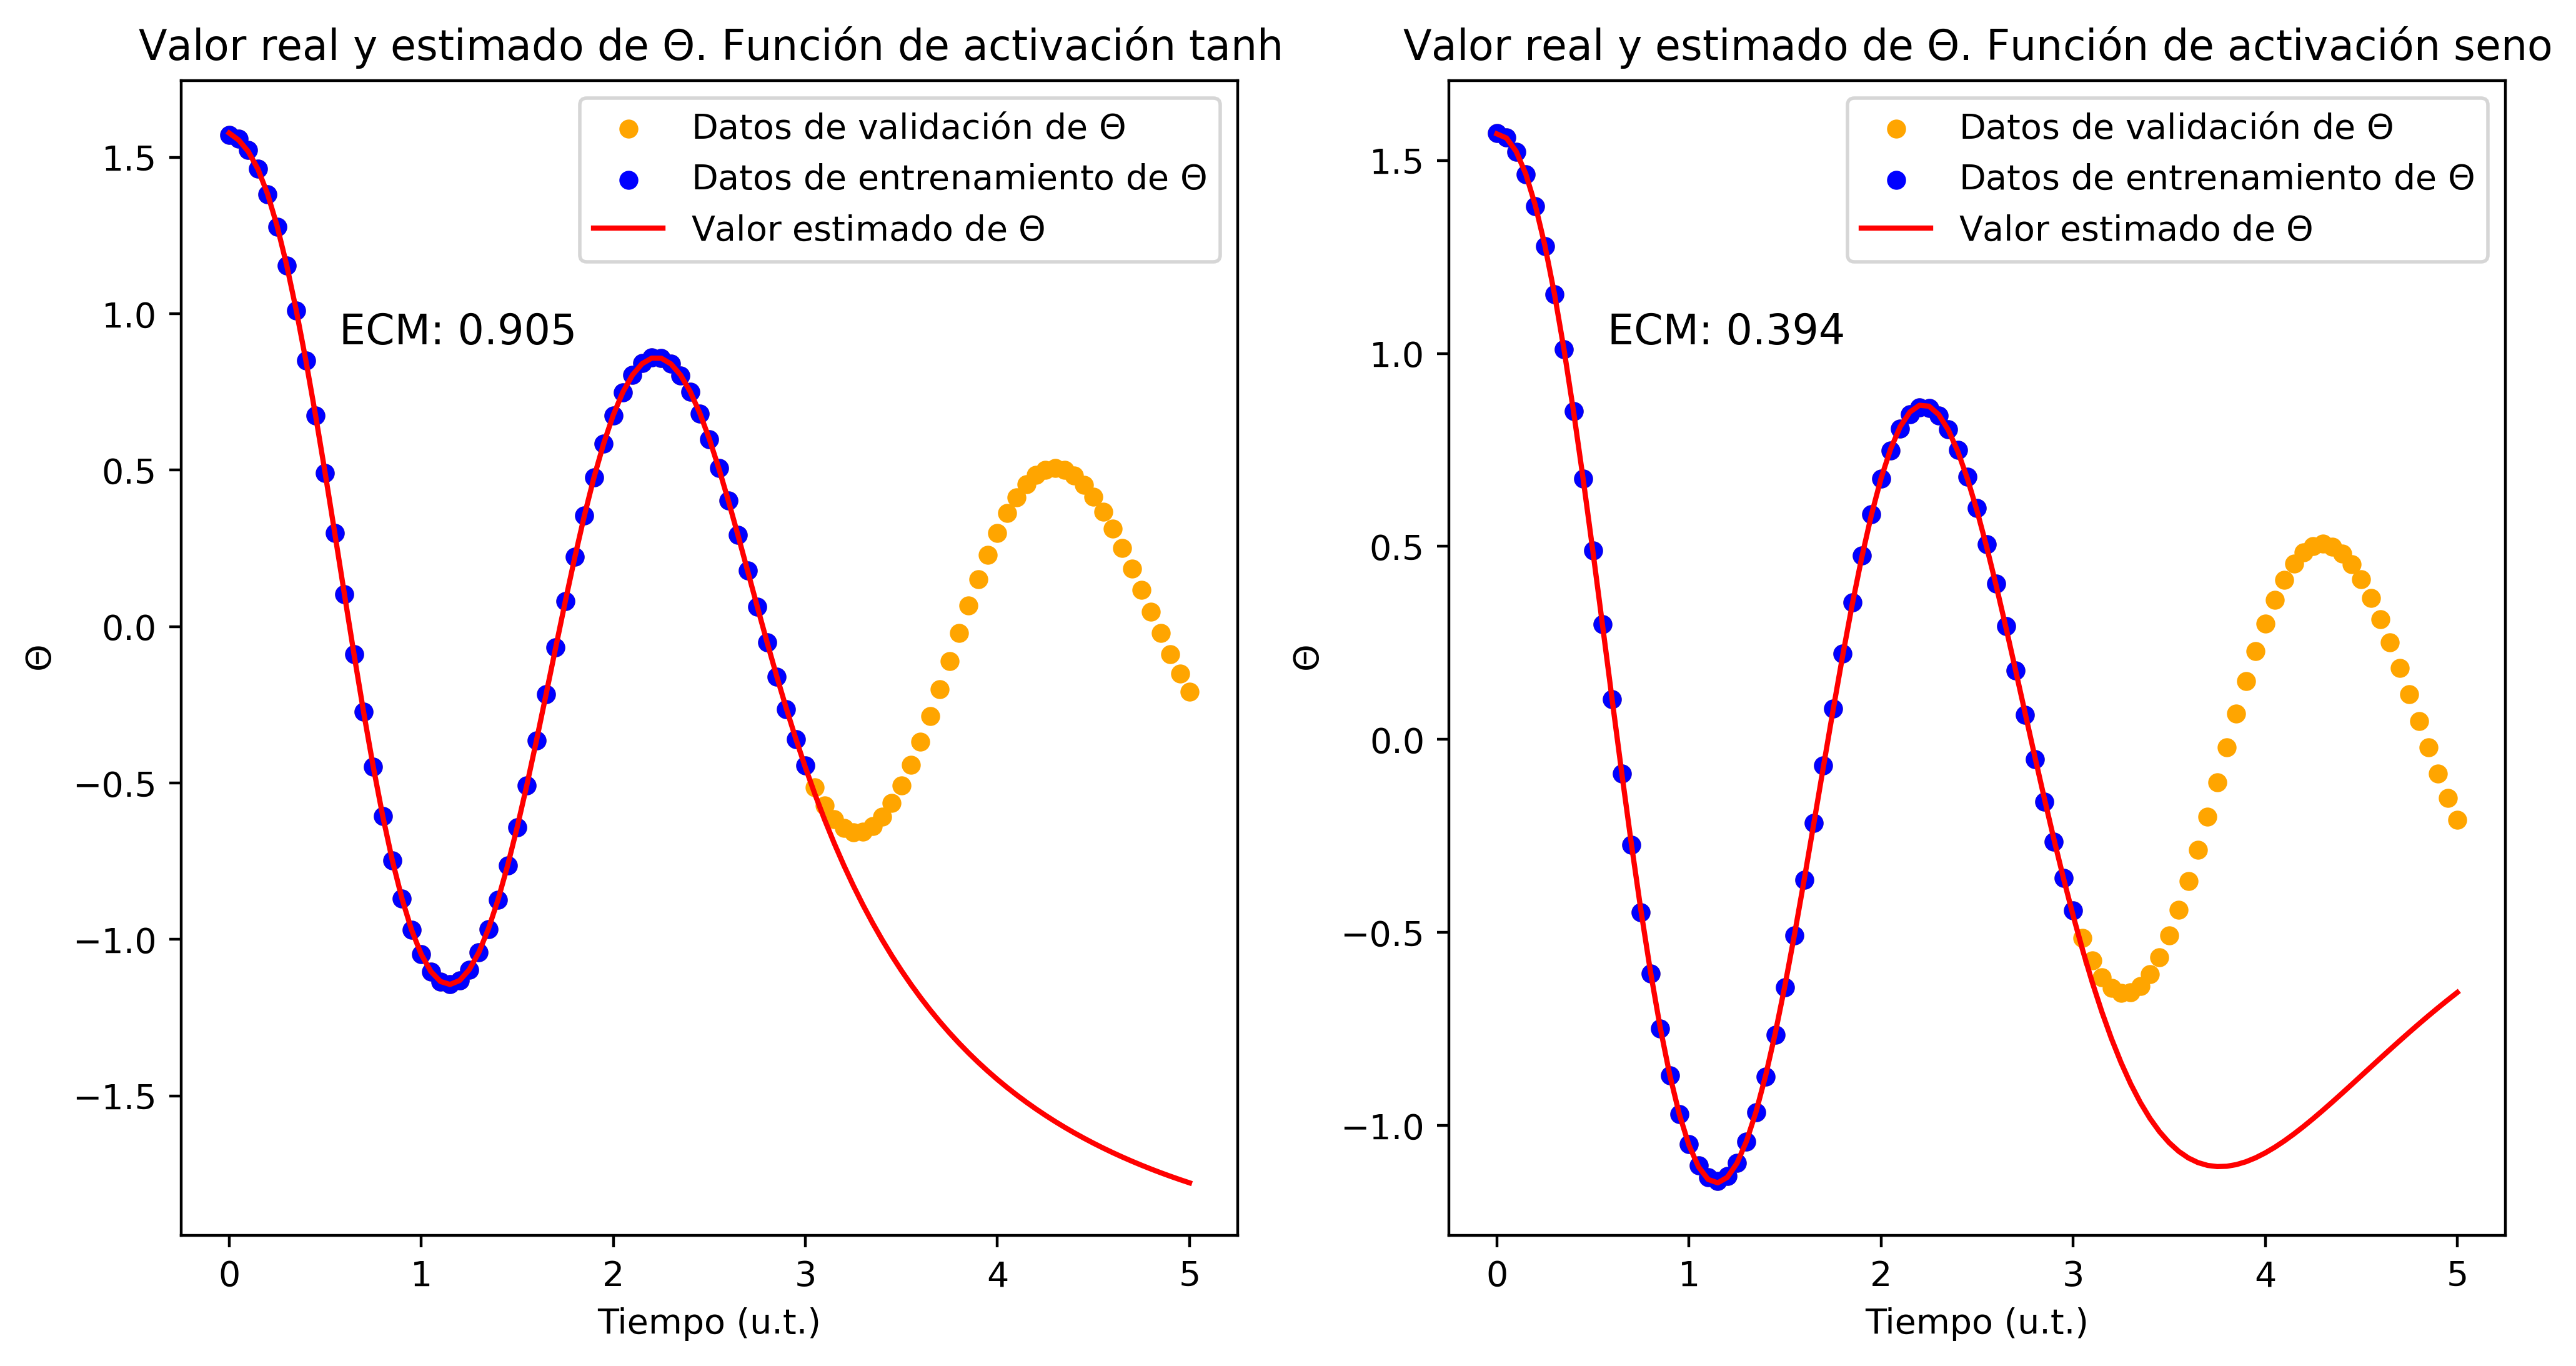

In [10]:
# Predict using the trained model
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
t_tensor = tf.reshape(t_tensor, (-1, 1))
theta_pred_sin = model_nn_sin(t_tensor).numpy()
theta_pred_tanh = model_nn_tanh(t_tensor).numpy()

# Plot the results
plt.figure(figsize=(12, 6), dpi=400)
plt.subplot(1, 2, 1)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred_tanh[:, 0], label=r'Valor estimado de $\Theta$', color='red')
mse_tanh = np.mean((actual_theta[:, 0] - theta_pred_tanh[:, 0]) ** 2)
plt.text(0.15, 0.8, f'ECM: {mse_tanh:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'Valor real y estimado de $\Theta$. Función de activación tanh')

plt.subplot(1, 2, 2)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, theta_pred_sin[:, 0], label=r'Valor estimado de $\Theta$', color='red')
mse_sine = np.mean((actual_theta[:, 0] - theta_pred_sin[:, 0]) ** 2)
plt.text(0.15, 0.8, f'ECM: {mse_sine:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend()
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.title(r'Valor real y estimado de $\Theta$. Función de activación seno')

plt.show()
